<a href="https://colab.research.google.com/github/Karthikreddy1010/Real-estate-price-prediction/blob/main/realestate_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**REAL ESTATE PRICE PREDICTION BY USING SVR AND RANDOMFOREST REGRESSOR MODELS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import warnings
warnings.filterwarnings('ignore')


In [2]:
data=pd.read_csv('Banglore1.csv')
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


THE SIZE AND TOTAL_SQFT ARE IN OBJECT TYPE SO, AFTER CONVERTING IN TO INT TYPE THEN BY USING DESCRIBE FUNCTION WE CAN GET STATISTICS  OF ALL COLUMNS NOW ONLY GET ABOUT BATH,BALCONY,PRICE

In [4]:
data.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [5]:
print("SHAPE OF DATA:",data.shape)

SHAPE OF DATA: (13320, 9)


In [6]:
print("Total null values in dataset:",data.isnull().sum())

Total null values in dataset: area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64


** The below cell the graph shows null values in percentage way **

1.   For example : society null values=5502
2.   Total length of dataset=13320
3.   percentage_society=5502/13320*100=41.306
4.   percentage_society=41.306
5.   In the same manner all null values columns is calculated to find percentage of null values





In [7]:
miss_value_per=pd.DataFrame(data.isnull().sum()/len(data)*100)
fig=px.bar(miss_value_per)
fig.update_layout(yaxis_title='percentage',
                 title='Missing values in percentage')
fig.show()

## It shows percentage of null values in a dataset

In [8]:
print("Size unique values:",data['size'].unique())

Size unique values: ['2 BHK' '4 Bedroom' '3 BHK' '4 BHK' '6 Bedroom' '3 Bedroom' '1 BHK'
 '1 RK' '1 Bedroom' '8 Bedroom' '2 Bedroom' '7 Bedroom' '5 BHK' '7 BHK'
 '6 BHK' '5 Bedroom' '11 BHK' '9 BHK' nan '9 Bedroom' '27 BHK'
 '10 Bedroom' '11 Bedroom' '10 BHK' '19 BHK' '16 BHK' '43 Bedroom'
 '14 BHK' '8 BHK' '12 Bedroom' '13 BHK' '18 Bedroom']


**Removing null values for the size column because it is a object type if I use mode to replace null values it shows outilers**

In [9]:
data=data.dropna(subset=['size'])

In [10]:
## By using regular expressions I removed character like BHK, bedroom tags to size column because it is a important feature so, I have to convert in to integer
data['size']=data['size'].str.extract('(\d+)').astype(int)

In [11]:
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2,NaN,1200,2.0,1.0,51.00


To Replace Null values Location , society is replaced by mode- frequent because these columns are object datatype. Bath concists of outliers so I used median values to replave the null values. for Balcony there is no outliers so I used mean value to repalce the null values.
**I used Simple Imputer package to replace null values**

In [12]:
from sklearn.impute import SimpleImputer

def get_parameters(data):
    parameters = {}
    for col in data.columns[data.isnull().any()]:
        if col == 'bath':  # Special condition for 'bath' column
            strategy = 'median'
        elif data[col].dtype in ['float64', 'int64', 'int32']:
            strategy = 'mean'
        else:
            strategy = 'most_frequent'
        missing_values = data[col][data[col].isnull()].values[0]
        parameters[col] = {'missing_values': missing_values, 'strategy': strategy}
    return parameters
# Retrieve the parameters for imputation
parameters = get_parameters(data)

In [13]:
parameters
# most frequent--mode

{'location': {'missing_values': nan, 'strategy': 'most_frequent'},
 'society': {'missing_values': nan, 'strategy': 'most_frequent'},
 'bath': {'missing_values': nan, 'strategy': 'median'},
 'balcony': {'missing_values': nan, 'strategy': 'mean'}}

In [14]:
# Apply the imputation for each column
for col, param in parameters.items():
    missing_values = param['missing_values']
    strategy = param['strategy']
    imp = SimpleImputer(missing_values=missing_values, strategy=strategy)

    # Perform the imputation
    transformed_col = imp.fit_transform(data[[col]]).reshape(-1)
    data[col] = transformed_col

In [15]:
print("Null values:",data.isnull().sum())

Null values: area_type       0
availability    0
location        0
size            0
society         0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64


** Now there is no values in data but there is outliers**

In [16]:
# converting bath and balcony into int type

data['bath']=data['bath'].astype(int)
data['balcony']=data['balcony'].astype(int)

**By using regular expressions , I have to extract the total_sqft because in total_sqft contains like 1000 meters, 2000 Sqft so, to convert in int type** **by removing all tags**

In [17]:
# Process 'total_sqft' column to handle different units and ranges
def process_total_sqft(total_sqft):
    if '-' in total_sqft:
        start, end = total_sqft.split('-')
        return int((float(start) + float(end)) // 2)  # Take the average of the range
    elif re.match(r'^\d+\.?\d*\s*([Ss][qQ]\.?\s*[Mm][Ee][Tt][Ee][Rr]|[Ss][qQ]\.?\s*[Ff][Tt])$', total_sqft):
        # Handle cases like '34.46Sq. Meter' or '2345 Sq. Ft' by extracting the numerical part
        sqft_value = re.findall(r'\d+\.?\d*', total_sqft)[0]
        return int(float(sqft_value))
    elif re.match(r'^\d+\.?\d*\s*[Pp][Ee][Rr][Cc][Hh]$', total_sqft):
        # Handle cases like '4125Perch'
        perch_value = re.findall(r'\d+\.?\d*', total_sqft)[0]
        # 1 Perch is approximately equal to 272.25 square feet
        return int(float(perch_value) * 272.25)
    elif re.match(r'^\d+\.?\d*\s*[Ss][qQ]\.?\s*[Yy][Aa][Rr][Dd][Ss]?$', total_sqft):
        # Handle cases like '1100Sq. Yards'
        yards_value = re.findall(r'\d+\.?\d*', total_sqft)[0]
        # 1 Sq. Yard is approximately equal to 9 square feet
        return int(float(yards_value) * 9)
    elif re.match(r'^\d+\.?\d*\s*[Aa][Cc][Rr][Ee][Ss]?$', total_sqft):
        # Handle cases like '5.31Acres'
        acres_value = re.findall(r'\d+\.?\d*', total_sqft)[0]
        # 1 Acre is equal to 43560 square feet
        return int(float(acres_value) * 43560)
    elif re.match(r'^\d+\.?\d*\s*[Cc][Ee][Nn][Tt][Ss]?$', total_sqft):
        # Handle cases like '3Cents'
        cents_value = re.findall(r'\d+\.?\d*', total_sqft)[0]
        # 1 Cent is equal to 435.6 square feet
        return int(float(cents_value) * 435.6)
    elif re.match(r'^\d+\.?\d*\s*[Gg][Uu][Nn][Tt][Hh][Aa]$', total_sqft):
        # Handle cases like '24Guntha'
        guntha_value = re.findall(r'\d+\.?\d*', total_sqft)[0]
        # 1 Guntha is approximately equal to 1089 square feet
        return int(float(guntha_value) * 1089)
    elif re.match(r'^\d+\.?\d*\s*[Gg][Rr][Oo][Uu][Nn][Dd][Ss]?$', total_sqft):
        # Handle cases like '1Grounds'
        grounds_value = re.findall(r'\d+\.?\d*', total_sqft)[0]
        # 1 Ground is equal to 2400 square feet
        return int(float(grounds_value) * 2400)
    else:
        return int(float(total_sqft))

data['total_sqft'] = data['total_sqft'].apply(process_total_sqft)

# Convert 'total_sqft' column to integer
data['total_sqft'] = data['total_sqft'].astype(int)

print(data)

                  area_type   availability                  location  size  \
0      Super built-up  Area         19-Dec  Electronic City Phase II     2   
1                Plot  Area  Ready To Move          Chikka Tirupathi     4   
2            Built-up  Area  Ready To Move               Uttarahalli     3   
3      Super built-up  Area  Ready To Move        Lingadheeranahalli     3   
4      Super built-up  Area  Ready To Move                  Kothanur     2   
...                     ...            ...                       ...   ...   
13315        Built-up  Area  Ready To Move                Whitefield     5   
13316  Super built-up  Area  Ready To Move             Richards Town     4   
13317        Built-up  Area  Ready To Move     Raja Rajeshwari Nagar     2   
13318  Super built-up  Area         18-Jun           Padmanabhanagar     4   
13319  Super built-up  Area  Ready To Move              Doddathoguru     1   

       society  total_sqft  bath  balcony   price  
0      Coom

**To check outliers By using Box plot**

In [18]:
# Assuming 'data' is your DataFrame
fig = px.box(data, x='size', title='size or BHK Boxplot')
fig.show()

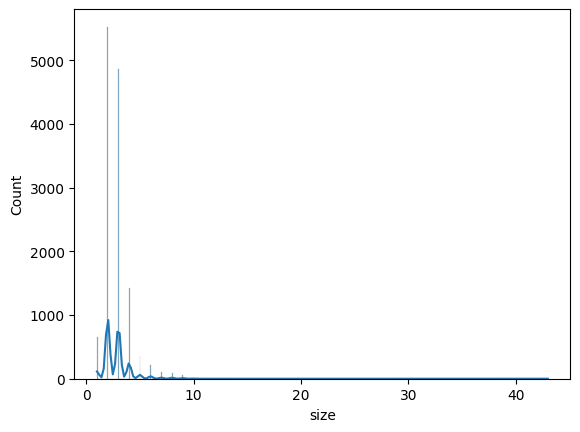

In [19]:
sns.histplot(data['size'],kde=True)
plt.show()

## In normal distribution all men, mode and median all values are same


In [20]:
# Assuming 'data' is your DataFrame
fig1 = px.box(data, x='bath', title='Number of Bathrooms Boxplot')
fig1.show()

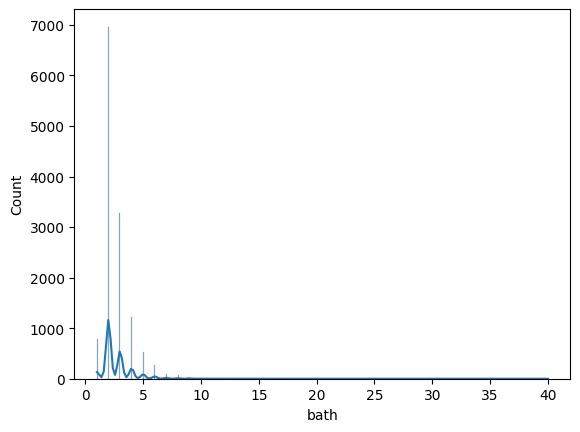

In [21]:
sns.histplot(data['bath'],kde=True)
plt.show()


In [22]:
fig2 = px.box(data, x='balcony', title='Number of Balcony Boxplot')
fig2.show()

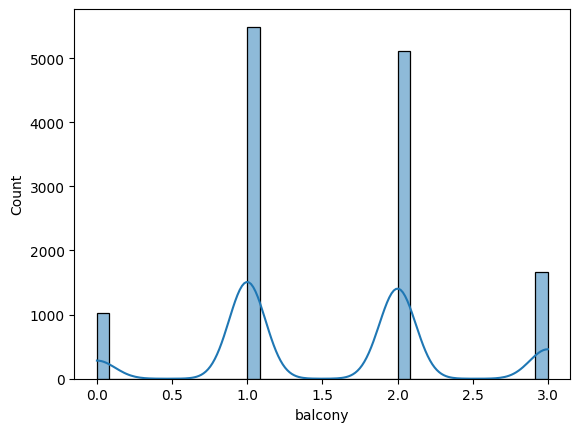

In [23]:
sns.histplot(data['balcony'],kde=True)
plt.show()

In [24]:
fig2 = px.box(data, x='price', title='Price Boxplot')
fig2.show()

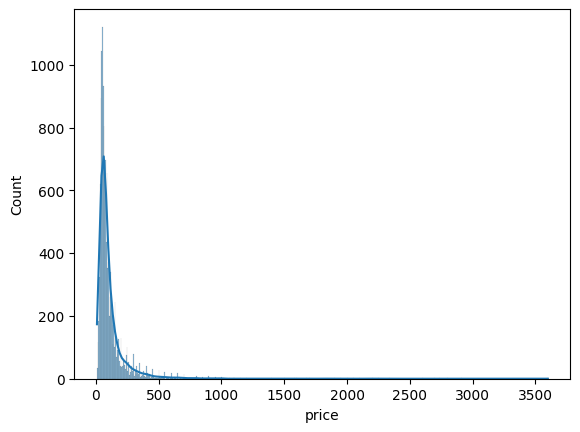

In [25]:
sns.histplot(data['price'],kde=True)
plt.show()

In [26]:
fig2 = px.box(data, x='total_sqft', title='Total_sqft Boxplot')
fig2.show()

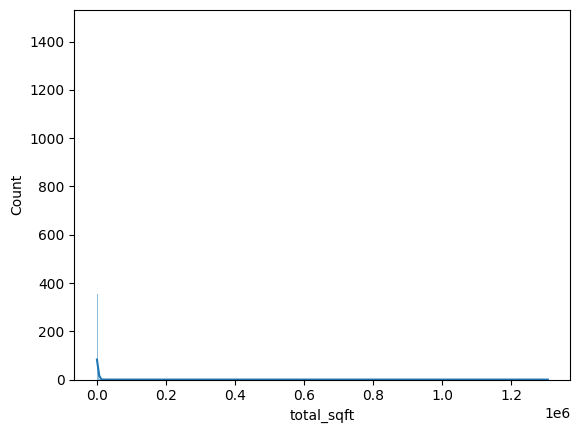

In [27]:
sns.histplot(data['total_sqft'],kde=True)
plt.show()

**So, in size, bath, price, total_sqft have outliers by using IQR we can remove outliers**

In [28]:
before_outliers=data.describe()

In [29]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to each numeric column
numeric_columns = ['bath', 'balcony', 'price','total_sqft','size']
for column in numeric_columns:
    data = remove_outliers(data, column)

print(data.shape)


(10588, 9)


** So After removing outliers the data shape is decreased**


1.   Before removing Outliers data shape=(13320,9)
2.   After removing Outliers data shape=(10588,9)



In [30]:
after_outlier=data.describe()

In [31]:
print("Before removing outliers:",before_outliers)

print("After removing outliers:",after_outlier)

Before removing outliers:                size    total_sqft          bath       balcony         price
count  13304.000000  1.330400e+04  13304.000000  13304.000000  13304.000000
mean       2.803743  1.904447e+03      2.689642      1.558328    112.582035
std        1.294974  1.728428e+04      1.339345      0.807892    148.988398
min        1.000000  1.000000e+00      1.000000      0.000000      8.000000
25%        2.000000  1.100000e+03      2.000000      1.000000     50.000000
50%        3.000000  1.275000e+03      2.000000      2.000000     72.000000
75%        3.000000  1.680000e+03      3.000000      2.000000    120.000000
max       43.000000  1.306800e+06     40.000000      3.000000   3600.000000
After removing outliers:                size    total_sqft          bath       balcony         price
count  10588.000000  10588.000000  10588.000000  10588.000000  10588.000000
mean       2.411598   1265.081413      2.260672      1.537684     70.355554
std        0.651687    331.686750    

**Now we can check whether outliers are removed or not, By using box plots and histogram plots**

In [32]:
fig = px.box(data, x='size', title='size or BHK Boxplot')
fig.show()

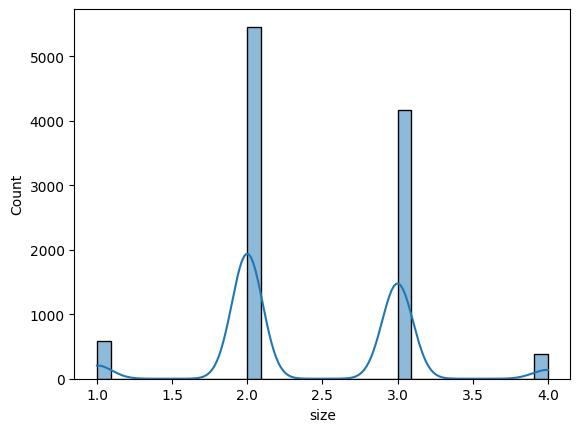

In [33]:
sns.histplot(data['size'],kde=True)
plt.show()

In [34]:
fig1 = px.box(data, x='bath', title='Number of Bathrooms Boxplot')
fig1.show()

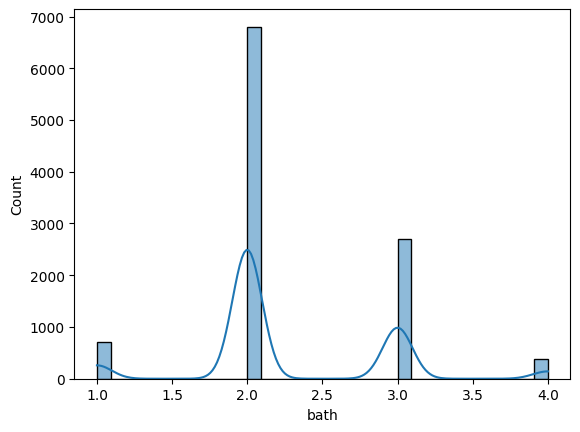

In [35]:
sns.histplot(data['bath'],kde=True)
plt.show()

In [36]:
fig2 = px.box(data, x='price', title='Price Boxplot')
fig2.show()

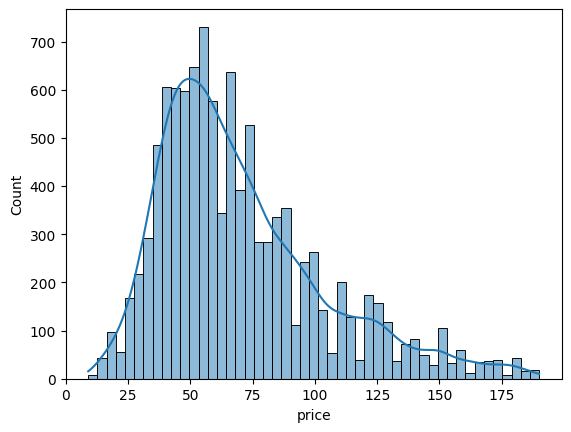

In [37]:
sns.histplot(data['price'],kde=True)
plt.show()

In [38]:
fig2 = px.box(data, x='total_sqft', title='Total_sqft Boxplot')
fig2.show()

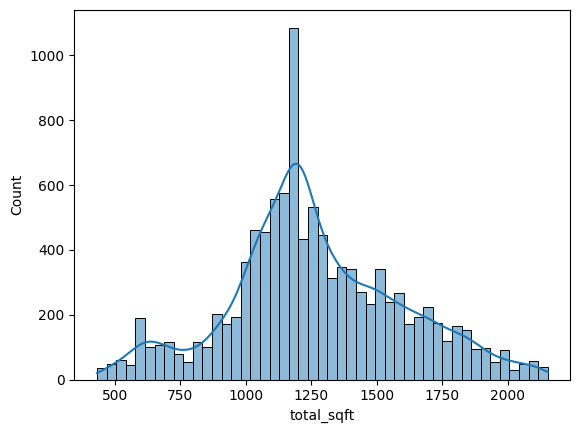

In [39]:
sns.histplot(data['total_sqft'],kde=True)
plt.show()

**After Applying IQR method aslo, there is outliers in price and total_sqft so, to control the outliers used log transform. Log transformation helps stabilize variance and reduce skewness in data, making it more normally distributed and improving model performance. It compresses large values, mitigating the influence of outliers and simplifying relationships between variables. This technique is especially useful for financial data, count data, and any situation with exponential growth.**

**Hot encoding to convert object type columns into boolean type**

In [40]:
data=pd.get_dummies(data,columns=['availability','location','area_type','society'])
numerical_cols=['total_sqft', 'bath', 'balcony', 'price','size']

data[numerical_cols]=data[numerical_cols].apply(pd.to_numeric)
print(data.head())


   size  total_sqft  bath  balcony  price  availability_14-Jul  \
0     2        1056     2        1  39.07                False   
2     3        1440     2        3  62.00                False   
3     3        1521     3        1  95.00                False   
4     2        1200     2        1  51.00                False   
5     2        1170     2        1  38.00                False   

   availability_14-Nov  availability_15-Aug  availability_15-Dec  \
0                False                False                False   
2                False                False                False   
3                False                False                False   
4                False                False                False   
5                False                False                False   

   availability_15-Jun  ...  society_Xeitaa   society_YCnce R  \
0                False  ...            False            False   
2                False  ...            False            False   

In [41]:
data=data.astype(int)

In [42]:
# Applying log transform to price and total_sqft column to control outliers

# Define a function for log transformation
def log_transform(df, column):
    df[column + '_log'] = np.log(df[column] + 1)  # Adding 1 to avoid log(0)
    return df
# Apply log transformation
data = log_transform(data, 'price')
data = log_transform(data, 'total_sqft')


In [43]:
X=data.drop(columns=['price'])
y=data['price']

In [44]:
print("X columns or Features:",X.head())
print("Y columns or target:",y.head())

X columns or Features:    size  total_sqft  bath  balcony  availability_14-Jul  availability_14-Nov  \
0     2        1056     2        1                    0                    0   
2     3        1440     2        3                    0                    0   
3     3        1521     3        1                    0                    0   
4     2        1200     2        1                    0                    0   
5     2        1170     2        1                    0                    0   

   availability_15-Aug  availability_15-Dec  availability_15-Jun  \
0                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   
5                    0                    0                    0   

   availability_15-Nov  ...  society_YMhenLi  society_Yaenti   \
0                    0

**80% of data is used for training purposes and remaining 20% is used for testing purposes**

In [45]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8470, 3536)
(2118, 3536)
(8470,)
(2118,)


**Applied Standard Scaler to rescale the numerical values**

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

**SVR MODEL**

In [47]:
from sklearn.svm import SVR
# Initialize the model with a linear kernel (you can try 'rbf', 'poly' as well)
svr_model = SVR(kernel='linear', C=1.0, epsilon=0.1)  # Adjust C and epsilon as needed
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

# Evaluate the model
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR Test MAE: {mae_svr}")
print(f"SVR Test MSE: {mse_svr}")
print(f"SVR R2 Score: {r2_svr}")


SVR Test MAE: 4.66647033420145
SVR Test MSE: 70.85336977757132
SVR R2 Score: 0.9386406803886216


In [48]:
# Create a DataFrame for easy plotting
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# Scatter plot of Actual vs Predicted values
fig = px.scatter(df, x='Actual', y='Predicted', trendline='ols',
                 title='SVR: Actual vs Predicted Values')
fig.show()


In [49]:
X_train.shape

(8470, 3536)

**Ensemble Learning Model**

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

# Example of ensemble with gradient boosting and random forest
model1 = GradientBoostingRegressor()
model2 = RandomForestRegressor()

ensemble_model = VotingRegressor(estimators=[('gb', model1), ('rf', model2)])
ensemble_model.fit(X_train, y_train)


VotingRegressor(estimators=[('gb', GradientBoostingRegressor()),
                            ('rf', RandomForestRegressor())])

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test data
y_pred = ensemble_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae}")
print(f"Test MSE: {mse}")
print(f"R2 Score: {r2}")


Test MAE: 0.047330478976107454
Test MSE: 0.00967721037390761
R2 Score: 0.9999916194946529


In [52]:
# Create a DataFrame for easy plotting
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Scatter plot of Actual vs Predicted values
fig = px.scatter(df, x='Actual', y='Predicted', trendline='ols',
                 title='Voting Regressor: Actual vs Predicted Values',
                 labels={'Actual': 'Actual Values', 'Predicted': 'Predicted Values'})
fig.show()


** RandomForest Regressor**

In [53]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with default parameters (you can adjust parameters as needed)
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)  # You can adjust n_estimators, max_depth, etc.
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Test MAE: {mae_rf}")
print(f"Random Forest Test MSE: {mse_rf}")
print(f"Random Forest R2 Score: {r2_rf}")


Random Forest Test MAE: 0.0055004721435315896
Random Forest Test MSE: 0.004411567516525028
Random Forest R2 Score: 0.9999961795637655


In [54]:
# Create a DataFrame for easy plotting
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})

# Scatter plot of Actual vs Predicted values
fig = px.scatter(df, x='Actual', y='Predicted', trendline='ols',
                 title='Random Forest: Actual vs Predicted Values',
                 labels={'Actual': 'Actual Values', 'Predicted': 'Predicted Values'})
fig.show()
